In [37]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
# import babet as bb
import netCDF4
import dask
import cartopy.crs as ccrs
import tqdm
import cartopy.feature as cfeature
from cmcrameri import cm

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
def preproc_ds(ds):
    """
    Main pre-processing function
    Writtten by Nick Leach and Shirin Ermis.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    ds1: xarray dataset with inidate dimension added
    """
    # remove any dimensions of length 1
    ds1 = ds.copy().squeeze()
    # set up aux data
    inidate = pd.to_datetime(ds1.time[0].values)
    # expand dimensions to include extra info
    if not 'hDate' in ds1:
        ds1 = ds1.expand_dims({'inidate': [inidate]}).copy()

    if not 'number' in ds1:
        ds1 = ds1.expand_dims({'number': [0]}).copy()

    # put time dimension at front
    ds1 = ds1.transpose('time', ...)
    return ds1

In [4]:
def hourly2accum(ds, start_day='2023-10-18 09', end_day='2023-10-22 00', m2mm=True):
    """
    Function to convert hourly precipitation to accumulated precipitation in mm.
    Also truncates the data to the desired time period.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    ds_out: xarray dataset with precipitation accumulated in mm.
    """
    if m2mm:
        factor = 1000
    else:
        factor = 1
    ds_out = ds.copy(deep=True).sel(time=slice(start_day, end_day))
    ds_out['tp'] = ds_out.tp.cumsum(dim='time')*factor  # sum and convert to mm

    return ds_out

# Import data

In [7]:
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/ENS/EU025/sfc/pf'
forecasts = xr.open_mfdataset(os.path.join(base_dir, '*.nc'), preprocess=preproc_ds, engine='netcdf4')

In [28]:
starttime = '2023-10-18 09'
endtime = '2023-10-22 00'

In [29]:
tp_cum = (forecasts.sel(time=slice(starttime, endtime)).sel(time=endtime).tp-forecasts.sel(time=starttime).tp).mean(dim=['number'])


In [32]:
# Plot settings

# # UK
# lat_max = 62
# lat_min = 47
# lon_min = -12
# lon_max = 5

#Europe
lat_max = 70
lat_min = 33
lon_min = -27
lon_max = 25

tp_min = 0 # Precipitation in mm
tp_max = 100

p_min = 970 # Pressure in hPa
p_max= 1030

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.w

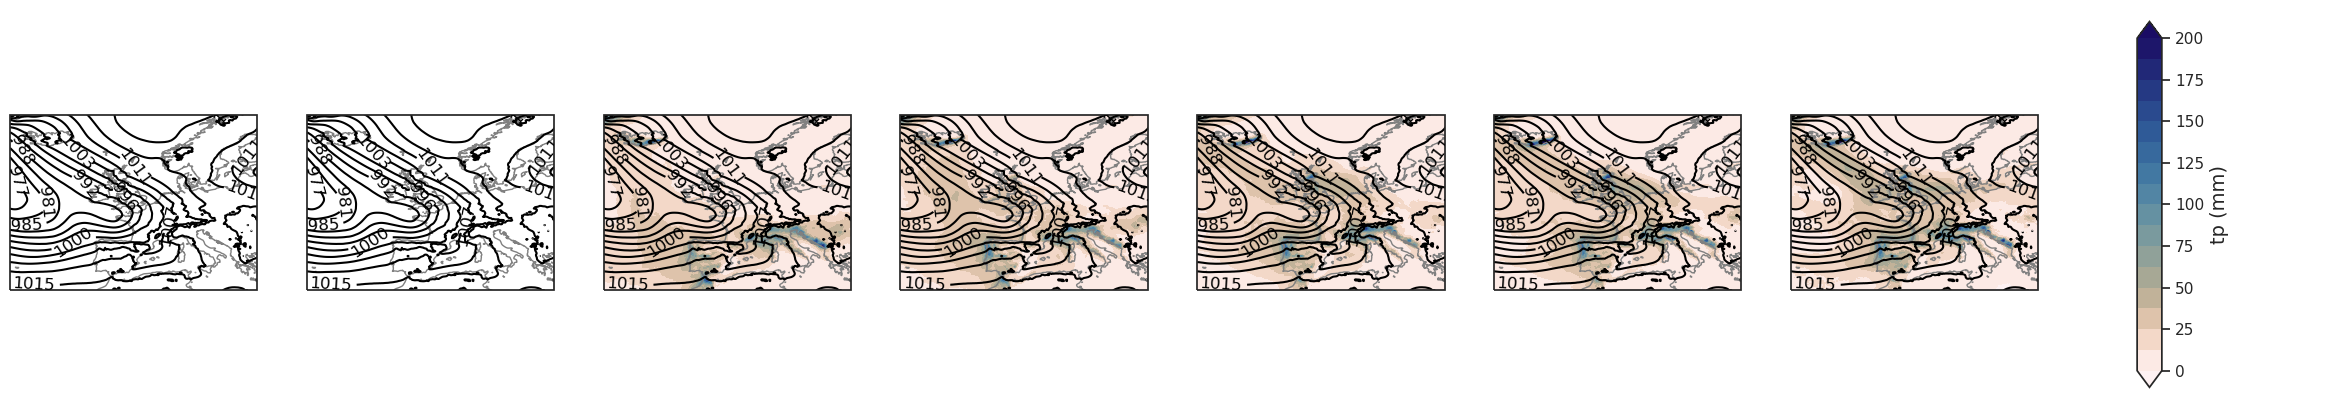

In [47]:
# figure and map setup
fs=14
projection = ccrs.PlateCarree()
longitude =forecasts.longitude.values
latitude = forecasts.latitude.values
fig = plt.figure(1, figsize=(30, 5))

# Map -----------------
for i, inidate in enumerate(forecasts.inidate.values):
    ax = plt.subplot(1,8,1+i, projection = projection)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

    # data for plotting
    tp_vals = tp_cum.sel(inidate=inidate).values*1000
    p_vals = forecasts.msl.sel(inidate='2023-10-15', time=starttime).mean('number').values/100

    # tp as shading
    clevs_tp = np.linspace(tp_min, tp_max, 17)
    cf = ax.contourf(longitude, latitude, tp_vals, clevs_tp, cmap=cm.lapaz_r,
                    transform=projection, 
                    extend='both')

    # isobars as contours
    clevs_p = np.linspace(p_min, p_max, 17)
    cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                    transform=projection)
    plt.clabel(cs, fmt='%d')

# Other figure settings -----------------
ax = plt.subplot(1,8,8)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='tp (mm)', extend = 'max', shrink=0.8)
cbar.set_label(label='tp (mm)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)
